# <a href="https://colab.research.google.com/github/makagan/TRISEP_Tutorial/blob/main/Exercises/3.2.ConvNet-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST + MLP + CNN

Adapted from [notebooks](https://github.com/odsl-team/block-course-apr24-ML/tree/main/Exercises) developed by Baran Hashemi and [notebook](https://github.com/drinkingkazu/TRISEP2022ML/blob/master/NeuralNetworks/NN-01-CNN.ipynb) by Kazuhiro Terao



In this notebook, we will explore convolution filters, and then design and train a Convolutional Neural Network (CNN) for hand-written digit classification task. We use MNIST dataset that contains 28x28 pixel images of a hand-written digit (0 to 9, so 10 classification targets). 

## Goals
1. Explore how filters work
2. Design CNN and train on MNIST

Let's start with usual import!

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.device(device)
import numpy as np
SEED=12345
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)


## Part 1: Understanding Convlutions

## Step 0: Some later required functions

In [2]:
# Some Plotting Functions

def show_grating(img, ax=None, show=False):
  """Visualize a grating"""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img+0.5, cmap=mpl.cm.binary)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  if show:
    plt.show()


def plot_weights(weights, channels=[0]):
  """ plot convolutional channel weights
  Args:
      weights: weights of convolutional filters (conv_channels x K x K)
      channels: which conv channels to plot
  """
  wmax = torch.abs(weights).max()
  fig, axs = plt.subplots(1, len(channels), figsize=(12, 2.5))
  for i, channel in enumerate(channels):
    im = axs[i].imshow(weights[channel, 0], vmin=-wmax, vmax=wmax, cmap='bwr')
    axs[i].set_title(f'channel {channel}')

    cb_ax = fig.add_axes([1, 0.1, 0.05, 0.8])
    plt.colorbar(im, ax=cb_ax)
    cb_ax.axis('off')
  plt.show()


def plot_example_activations(grating, act, channels=[0]):
  """ plot activations act and corresponding grating
  Args:
    grating: image input to convolutional layer (n x h x w) or (h x w)
    act: activations of convolutional layer (n_bins x conv_channels x n_bins)
    channels: which conv channels to plot
  """
  if grating.ndim>2:
    n_grating = grating.shape[0]
  else:
    grating = grating.unsqueeze(0)
    n_grating = 1

  fig, axs = plt.subplots(n_grating, 1 + len(channels), figsize=(12, 12))

  # plot grating
  for i in range(n_grating):
    show_grating(grating[i].squeeze(), ax=axs[i, 0])
    axs[i, 0].set_title('grating')

    # plot example activations
    for k, (channel, ax) in enumerate(zip(channels, axs[i][1:])):
      im = ax.imshow(act[i, channel], vmin=-3, vmax=3, cmap='bwr')
      ax.set_xlabel('x-pos')
      ax.set_ylabel('y-pos')
      ax.set_title(f'channel {channel}')

    cb_ax = fig.add_axes([1.05, 0.8, 0.01, 0.1])
    plt.colorbar(im, cax=cb_ax)
    cb_ax.set_title('activation\n strength')
  plt.show()

In [3]:
def grating(angle, sf=1 / 28, res=0.1, patch=False):
  """Generate oriented grating 

  Args:
    angle (float): orientation of grating (angle from vertical), in degrees
    sf (float): controls spatial frequency of the grating
    res (float): resolution of image. Smaller values will make the image
      smaller in terms of pixels. res=1.0 corresponds to 640 x 480 pixels.
    patch (boolean): set to True to make the grating a localized
      patch on the left side of the image. If False, then the
      grating occupies the full image.

  Returns:
    torch.Tensor: (res * 480) x (res * 640) pixel oriented grating image

  """

  angle = np.deg2rad(angle)  # transform to radians

  wpix, hpix = 640, 480  # width and height of image in pixels for res=1.0

  xx, yy = np.meshgrid(sf * np.arange(0, wpix * res) / res, sf * np.arange(0, hpix * res) / res)

  if patch:
    gratings = np.cos(xx * np.cos(angle + .1) + yy * np.sin(angle + .1))  # phase shift to make it better fit within patch
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1
    xcent = gratings.shape[1] * .75
    ycent = gratings.shape[0] / 2
    xxc, yyc = np.meshgrid(np.arange(0, gratings.shape[1]), np.arange(0, gratings.shape[0]))
    icirc = ((xxc - xcent) ** 2 + (yyc - ycent) ** 2) ** 0.5 < wpix / 3 / 2 * res
    gratings[~icirc] = 0.5

  else:
    gratings = np.cos(xx * np.cos(angle) + yy * np.sin(angle))
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1

  gratings -= 0.5

  # Return torch tensor
  return torch.tensor(gratings, dtype=torch.float32)

## Step 1: Image Processing

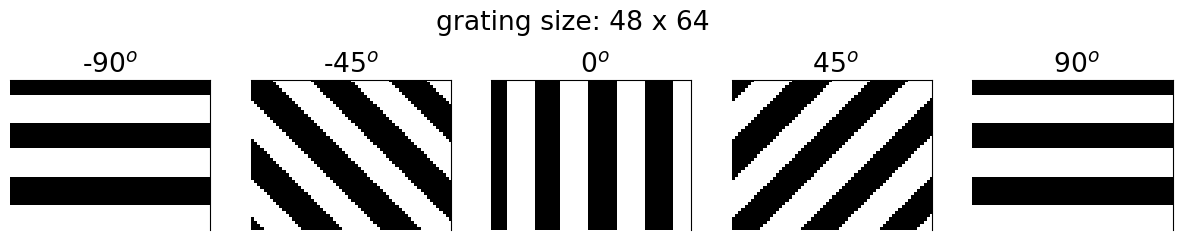

In [4]:
#Execute this cell to plot example grating

orientations = np.linspace(-90, 90, 5) # You can play with the orientations

h_ = 3
n_col = len(orientations)
h, w  = grating(0).shape  # height and width of grating

fig, axs = plt.subplots(1, n_col, figsize=(h_ * n_col, h_))
for i, ori in enumerate(orientations):
  grat = grating(ori)
  axs[i].set_title(f'{ori: .0f}$^o$')
  show_grating(grat, axs[i])
fig.suptitle(f'grating size: {h} x {w}')
plt.show()

Let's implement 2D convolutional operations. We will use multiple convolutional channels and implement this operation efficiently using pytorch. A *layer* of convolutional channels can be implemented with one line of code using the PyTorch class `nn.Conv2d()`, which requires the following arguments for initialization (see full documentation [here](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html)):
  * $C^{in}$: the number of input channels
  * $C^{out}$: the number of output channels (number of different convolutional filters)
  * $K$: the size of the $C^{out}$ different convolutional filters

When you run the network, you can input an image of arbitrary size $(H^{in}, W^{in})$, but it needs to be shaped as a 4D input $(N, C^{in}, H^{in}, W^{in})$, where $N$ is the number of samples. In our case, $C^{in}=1$ because there is only one color channel (our images are grayscale, but often $C^{in}=3$ in image processing).

In [5]:
class ConvolutionalLayer(torch.nn.Module):
  """Deep network with one convolutional layer
     Attributes: conv (nn.Conv2d): convolutional layer
  """
  def __init__(self, c_in=1, c_out=2, K=3, filters=None):
    """Initialize layer

    Args:
        c_in: number of input image channels
        c_out: number of output convolutional channels
        K: size of each convolutional filter
        filters: (optional) initialize the convolutional weights

    """
    super().__init__()
    self.conv = torch.nn.Conv2d(c_in, c_out, kernel_size=K,
                          padding=K//2, stride=1)
    if filters is not None:
      self.conv.weight = torch.nn.Parameter(filters)
      self.conv.bias = torch.nn.Parameter(torch.zeros((c_out,), dtype=torch.float32))

  def forward(self, s):
    """Run convolutional layer on images

    Args:
        s (torch.Tensor): n_samples x c_in x h x w tensor of the images

    Returns:
        (torch.Tensor): n_samples x c_out x h x w tensor with convolutional layer unit activations.

    """
    a = self.conv(s)  # output of convolutional layer

    return a

See that `ConvolutionalLayer` takes as input `filters`. We have predesigned some filters that you can use by calling the `filters` function below. These are similar to filters we think are implemented in biological circuits such as the retina and the visual cortex. In general, these filters will be learned in training based on the down-stream task.


In [6]:
def _filters(out_channels=2):
    """ Create example filters for vertical and horizontal edge detection.
    Returns:
        filters: out_channels x 1 x K x K (torch tensor)
    """
    # Initialize filters array
    filters = np.zeros((2, 3, 3), dtype=np.float32)

    # Vertical edge filter
    filters[0, :, :] = np.array([[1, 0, -1],
                                 [1, 0, -1],
                                 [1, 0, -1]])

    # Horizontal edge filter
    filters[1, :, :] = np.array([[1, 1, 1],
                                 [0, 0, 0],
                                 [-1, -1, -1]])

    # Normalize to range [-1, 1] to maintain consistent intensity
    filters /= np.abs(filters).max()

    # Convert to torch tensor
    filters = torch.from_numpy(filters)

    # Add channel dimension (1 in channel)
    filters = filters.unsqueeze(1)

    return filters

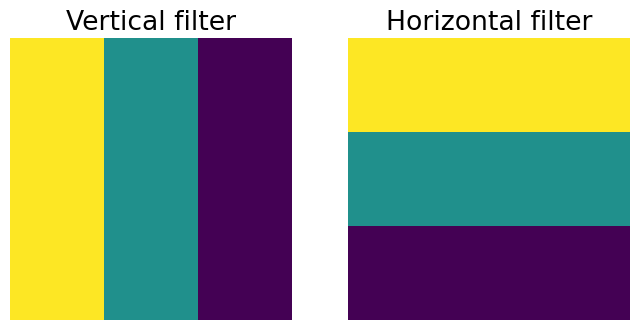

In [7]:
example_filters = _filters(out_channels=2) #torch.Size([2, 1, 3, 3])

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(example_filters[0,0], vmin=-1, vmax=1, cmap = 'viridis')
plt.title('Vertical filter')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(example_filters[1,0], vmin=-1, vmax=1, cmap = 'viridis')
plt.title('Horizontal filter')
plt.axis('off')
plt.show()

### Coding Exercise 1: 2D convolution in PyTorch

We will now run the convolutional layer on our grating. We will use gratings made using the function `grating`, which returns a iamge which is 48 x 64.

Reminder, `nn.Conv2d` takes in a tensor of size $(N, C^{in}, H^{in}, W^{in}$) where $N$ is the number of samples, $C^{in}$ is the number of input channels, and $(H^{in}, W^{in})$ is the size of the grating. We will need to add these first two dimensions to our samples, then input it to the convolutional layer.

We will plot the outputs of the convolution. `convout` is a tensor of size $(N, C^{out}, H^{in}, W^{in})$ where $N$ is the number of examples and $C^{out}$ are the number of convolutional channels. It is the same size as the input because we used a stride of 1 and padding that is half the kernel size.

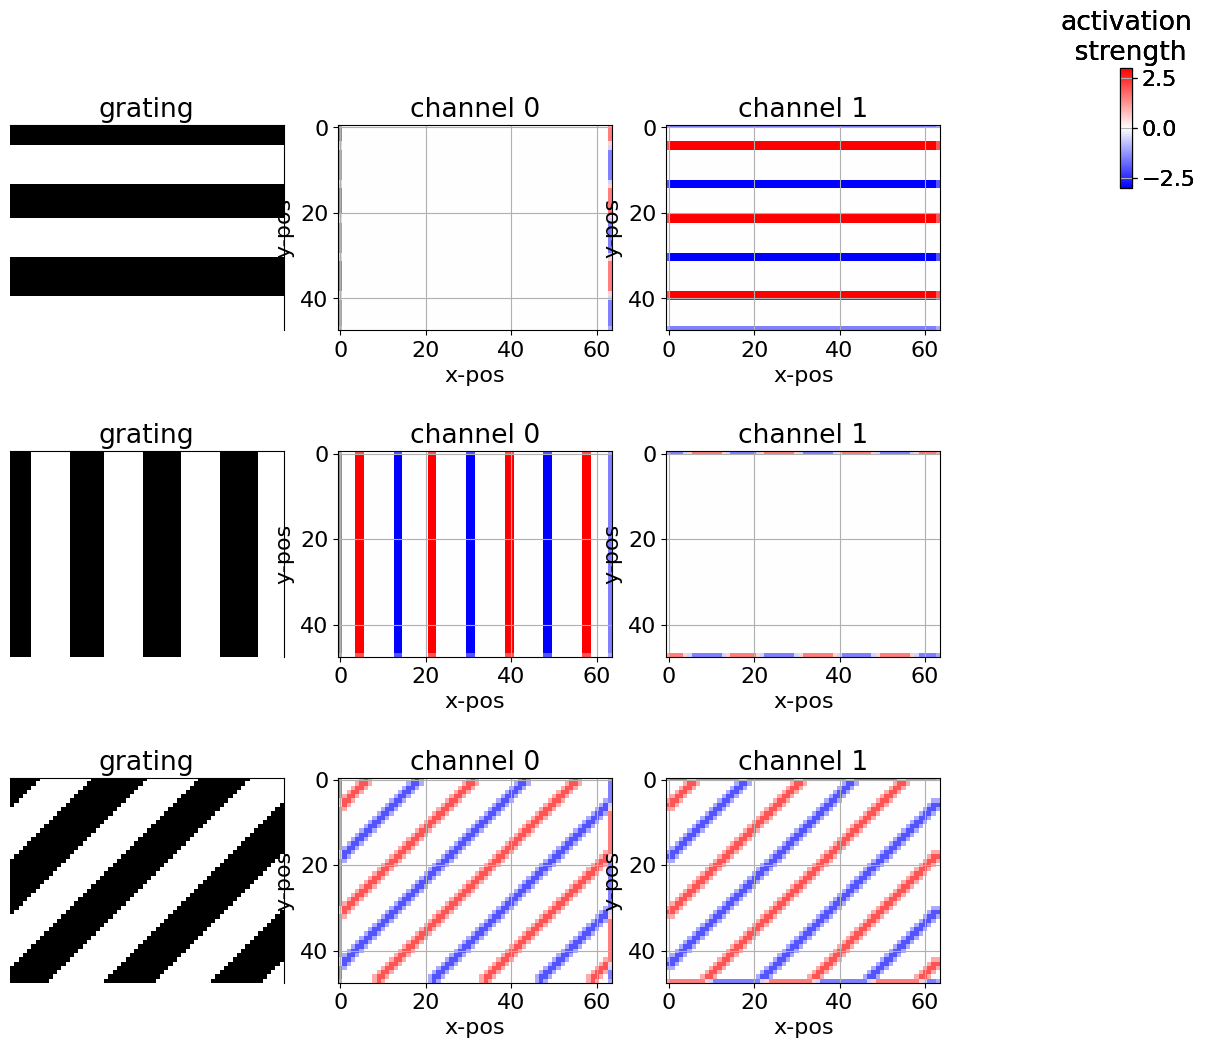

In [8]:
# Grating image parameters
in_channels = 1  # how many input channels in our images
h = 48  # height of images
w = 64  # width of images

# Convolution layer parameters
K = 2  # filter size 
out_channels = 2  # how many convolutional channels to have in our layer
example_filters = _filters(out_channels)  # create filters to use

convout = np.zeros(0)  # initizalize convolutional activations to convout

# TODO: Initialize conv layer and add weights from function filters
# you need to specify :
# * the number of input channels c_in
# * the number of output channels c_out
# * the filter size K
convLayer = ConvolutionalLayer(..., filters=example_filters)

# Create grating image (H_in, W_in)
orientations = [90, 0, 45]
grats = torch.zeros((len(orientations), in_channels, h, w), dtype=torch.float32)
for i,ori in enumerate(orientations):
  grats[i, 0] = grating(ori, sf=1 / 28, res=0.1)

#TODO: apply the convLayer to the grating data 
convout = convLayer(...)
convout = convout.detach()  # detach gradients


plot_example_activations(grats, convout, channels=np.arange(0, out_channels))

Let's think about why the activations look the way they do:
The vertical edge filter is designed with weights that amplify changes in pixel intensity that occur from left to right across an image. The filter consists of positive weights on one side and negative weights on the other, creating a high response when there is a clear, vertical transition in pixel brightness. This makes the filter sensitive to vertical lines where there's a strong contrast, such as from white to black or black to white.
The sign of the activation depends on the direction of the luminance gradient. If the transition is from light (white) to dark (black) from left to right, the activation will be positive. Conversely, if the transition is from dark to light from left to right, the activation will be negative. This property allows the filter to not only detect the presence of a vertical edge but also infer the direction of the edge gradient.

## Part 2: Training a CNN on MNIST

## Create MNIST Dataset
Following the previous notebook, let's create train and test dataset and dataloader

In [2]:
from torchvision import datasets, transforms
# Data file download directory
LOCAL_DATA_DIR = './mnist-data'
# Use prepared data handler from pytorch (torchvision)
train_dataset = datasets.MNIST(LOCAL_DATA_DIR, train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=4)

# Use prepared data handler from pytorch (torchvision)
test_dataset = datasets.MNIST(LOCAL_DATA_DIR, train=False, download=True,
                              transform=transforms.Compose([transforms.ToTensor()]))

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=32,
                                          shuffle=False,
                                          num_workers=4)

### Define train and test functions

In [3]:
from ipywidgets import IntProgress
from IPython.display import display
from torch.utils.tensorboard import SummaryWriter
import time

def run_train(model, loader,  
              num_iterations=100, log_dir='log',
              lr=0.001, optimizer='SGD', device=None):
    print("\nTraining...")
    tstart = time.time()
    if log_dir:
        writer = SummaryWriter(log_dir=log_dir)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = getattr(torch.optim,optimizer)(model.parameters(),lr=lr)
    f = IntProgress(min=0,max=int(num_iterations/100),bar_style='info')
    display(f)
    
    iteration = 0
    while iteration < num_iterations:
        for data,label in loader:
            
            if device:
                data,label = data.to(device),label.to(device)

            loss = criterion(model(data), label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if log_dir: 
                writer.add_scalar('loss/train', loss.item(), iteration)
            if iteration%100 == 0:
                f.value += 1
            # Brake if we consumed all iteration counts
            iteration += 1
            if iteration >= num_iterations:
                break
    print('done',time.time()-tstart,'[s]')

def run_test(model,loader,device=None):

    label_v, softmax_v = [],[]
    softmax = torch.nn.Softmax(dim=1)
    f = IntProgress(min=0,max=int(len(loader)),bar_style='info')
    display(f)
    
    with torch.set_grad_enabled(False):
        for data,label in loader:
            if device:
                data,label = data.to(device), label.to(device)
            label_v.append  ( label.detach().reshape(-1)   )
            softmax_v.append( softmax(model(data)).detach())
            f.value += 1
    return torch.concat(label_v).cpu().numpy(), torch.concat(softmax_v).cpu().numpy()


## Logistic regression with CNN

we design CNN to try the same task. Let's define 3 convolution layers followed by LeakyReLU for activation and MaxPool2d for downsampling.

In [4]:
class CNN(torch.nn.Module):
    def __init__(self,num_filters=16):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(1,num_filters,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(num_filters,num_filters*2,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(num_filters*2,num_filters*4,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(7,7))
        # classifier MLP
        self._classifier = torch.nn.Linear(num_filters*4,10)

    def forward(self, x):
        # extract features
        features = self._feature_extractor(x)
        # flatten the 3d tensor (2d space x channels = features)
        features = features.view(-1, np.prod(features.size()[1:]))
        # classify and return
        return self._classifier(features)

### Exercise 1

Now let's train this CNN model!

1. Train CNN for 4000 iterations with `Adam` optimizer on CPU, measure the time taken in wall-clock, plot the loss.
2. Do the same but using GPU.


You should see that, this time, GPU gave a good speed-up. This is because CNN takes many separate multiplications of weights with input local matrix, and that can benefit from parallelization = GPU is suited.

In [ ]:
%load_ext tensorboard

%tensorboard --logdir mnist_cnn

### Exercise 2

Run the inference on the test dataset. Compute the accuracy over the all images in the test dataset.

Plot a bar chart of class probabilities for a single sample from model output
`torch.nn.functional.softmax(...)`: Apply the softmax function to convert logits into probabilities.
use `plt.vlines(...)` to draw a line for the true label
you can use `plt.semilogy()` to have a log-scale y-axis

### Exercise 3
How many parameters are there in our CNN model?